In [60]:
import pandas as pd
import numpy as np
import math

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import MinMaxScaler 

from imblearn.combine import SMOTETomek

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras

## Load Data 

In [4]:
claims = pd.read_excel('/content/Claim_Data.xlsm')
predictors = pd.read_excel('/content/Predictor Dataset.xlsm')
loss = pd.read_excel('/content/Subsequent_Loss_Experience.xlsm')

In [ ]:
claims.head()

,hhld_id,clm_dates,aft_ind,pd_amt
0,6599,2010-12-09,1,5736.39
1,1454,2010-06-14,1,3257.49
2,13691,2011-01-08,1,8190.45
3,10347,2014-02-09,0,428.48
4,6051,2010-03-31,0,107.57


In [ ]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   hhld_id    5000 non-null   int64         
 1   clm_dates  5000 non-null   datetime64[ns]
 2   aft_ind    5000 non-null   int64         
 3   pd_amt     5000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 156.4 KB


In [ ]:
predictors.head()

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode
0,15937,2,1,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.0,1,25000.0,0,0,0.0,0,0,0,1,1,1,100,100,825.949106,35741
1,13778,1,1,35.644631,35.644631,35.644631,35.644631,235.735566,235.735566,235.735566,235.735566,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,1.5,1,25000.0,1,1,NaN,0,0,0,1,1,0,25,25,684.650216,87884
2,16063,1,1,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,1,False,1,0,0.0,0,2,2.0,0,FARMERS,5.0,1,50000.0,0,1,NaN,0,0,0,1,1,1,100,100,596.318289,81525
3,12789,1,1,17.882127,17.882127,17.882127,17.882127,22.585530,22.585530,22.585530,22.585530,1,1,0,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,0.0,1,100000.0,1,0,NaN,0,0,1,1,1,1,100,100,636.757859,35741
4,5122,1,1,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,2.5,1,25000.0,0,0,NaN,0,0,0,0,1,1,50,50,669.569992,59792


In [ ]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hhld_id          20000 non-null  int64  
 1   drvr_cnt         20000 non-null  int64  
 2   veh_cnt          20000 non-null  int64  
 3   min_age          20000 non-null  float64
 4   hoh_age          20000 non-null  float64
 5   max_age          20000 non-null  float64
 6   avg_age          20000 non-null  float64
 7   min_mon_lic      20000 non-null  float64
 8   hoh_mon_lic      20000 non-null  float64
 9   max_mon_lic      20000 non-null  float64
 10  avg_mon_lic      20000 non-null  float64
 11  cnt_yth          20000 non-null  int64  
 12  cnt_female       20000 non-null  int64  
 13  cnt_male         20000 non-null  int64  
 14  cnt_married      20000 non-null  int64  
 15  cnt_single       20000 non-null  int64  
 16  hoh_married      20000 non-null  bool   
 17  cnt_auto    

In [ ]:
loss.head()

,hhld_id,premium,pd_amt,loss_ratio,future_clm_ind
0,15937,133.6,0.0,0.0,0
1,13778,145.8,0.0,0.0,0
2,16063,167.0,0.0,0.0,0
3,12789,150.3,0.0,0.0,0
4,5122,117.0,0.0,0.0,0


In [ ]:
loss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hhld_id         20000 non-null  int64  
 1   premium         20000 non-null  float64
 2   pd_amt          20000 non-null  float64
 3   loss_ratio      20000 non-null  float64
 4   future_clm_ind  20000 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 781.4 KB


## Exploratory Data Analysis and Data Cleaning

### Claim Data

In [5]:
# number of unique household_id
len(np.unique(claims.hhld_id))

4382

In [ ]:
# find out not unique household id
# np.unique(claims.hhld_id)[np.unique(claims.hhld_id, return_counts = True)[1] != 1]

In [ ]:
cnt_of_claims = Counter(np.unique(claims.hhld_id, return_counts = True)[1])
temp = pd.DataFrame.from_dict(cnt_of_claims, orient='index').reset_index()
temp.columns = ['key','value']
temp

,key,value
0,1,2925
1,2,276
2,3,16
3,4,1


Text(0, 0.5, 'counts')

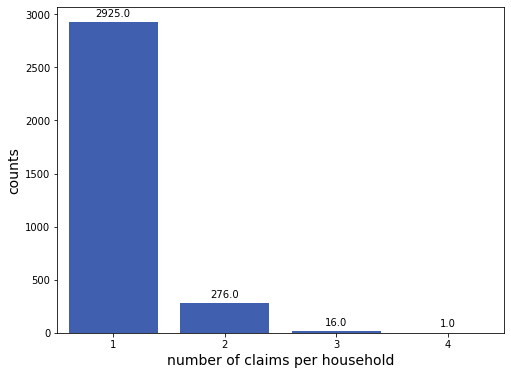

In [ ]:
plt.figure(figsize=(8, 6))
splot=sns.barplot(x="key",y="value",data=temp,color='#2F57C1')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("number of claims per household", size=14)
plt.ylabel("counts", size=14)

In [ ]:
# check how many claims are made before 1/1/2017
sum(claims.clm_dates < '2017-01-01')

4995

In [ ]:
# check how many claims have at least one dollar paid out
sum(claims.pd_amt >= 1)

4892

In [ ]:
# find out which claims are made after 1/1/2017 and exclude them
claims[claims.clm_dates >= '2017-01-01']

,hhld_id,clm_dates,aft_ind,pd_amt
665,4217,2017-03-27,1,0.00
1096,6285,2017-08-24,0,196.01
2363,2839,2017-05-05,0,152.94
4210,9722,2017-09-03,0,167.17
4901,19118,2017-10-10,0,128.79


In [6]:
# We want to focus on the last 5 year, so we also exclude the claims made before 1/1/2012
claims = claims[(claims.clm_dates < '2017-01-01') & (claims.clm_dates >= '2012-01-01') & (claims.pd_amt >= 1)]
claims.shape

(3529, 4)

### Predictor Data

In [7]:
# convert bool type variables to numeric
predictors.hoh_married = (predictors.hoh_married).astype(int)

In [8]:
# check that all hhld_id are unique
len(np.unique(predictors.hhld_id)) == len(predictors.hhld_id)

True

In [9]:
# check unqiue current insurer
np.unique(predictors.curnt_insurer, return_counts = True)

(array(['ALLSTATE', 'AMERICAN FAMILY', 'FARMERS', 'GEICO',
        'LIBERTY MUTUAL', 'MISSING', 'NATIONWIDE', 'OTHER', 'PROGRESSIVE'],
       dtype=object),
 array([1882,  593, 1299, 2079,  898, 7010,  709, 3665, 1865]))

In [10]:
cnt_of_insurertype = Counter(predictors.curnt_insurer)
temp = pd.DataFrame.from_dict(cnt_of_insurertype, orient='index').reset_index()
temp.columns = ['key','value']
temp = temp.sort_values('value', ascending=False)
temp

,key,value
3,MISSING,7010
1,OTHER,3665
6,GEICO,2079
4,ALLSTATE,1882
0,PROGRESSIVE,1865
2,FARMERS,1299
7,LIBERTY MUTUAL,898
8,NATIONWIDE,709
5,AMERICAN FAMILY,593


Text(0.5, 0, 'counts')

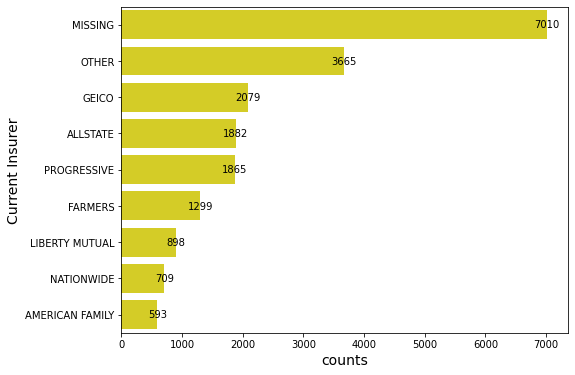

In [11]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(y="key", x="value",data=temp, orient='h', color='#F1E60A')
for p in splot.patches:
    width = p.get_width()
    plt.text(p.get_width(), p.get_y()+0.5*p.get_height(),
              '%d' % int(width),
              ha='center', va='center')
plt.ylabel("Current Insurer", size=14)
plt.xlabel("counts", size=14)

In [ ]:
# found that a 'MISSING' current insurer associats with NA's in 'time_w_carr' and 'prior_bi'
print(all(predictors.hhld_id[predictors.curnt_insurer == 'MISSING'] 
          == predictors.hhld_id[predictors.time_w_carr.isnull()]))
print(all(predictors.hhld_id[predictors.curnt_insurer == 'MISSING'] 
          == predictors.hhld_id[predictors.prior_bi.isnull()]))

True
True


In [12]:
# 'MISSING' current insurer also associates with 0 in 'inforce_ind', 
# so we can drop 'inforce_ind' to reduce multicollinearity
print(all(predictors.hhld_id[predictors.curnt_insurer == 'MISSING'] 
    == predictors.hhld_id[predictors.inforce_ind == 0]))
predictors = predictors.drop(columns = 'inforce_ind')

True


In [ ]:
# check if number of vehicles in the household equals to number of automobile and motorcycles
all(predictors.veh_cnt == predictors.cnt_auto + predictors.cnt_mtrcyc)

True

In [ ]:
# check if number of vehicles in the household is greater than or equal 
# to number of vehicle leased and owned
all(predictors.veh_cnt >= predictors.veh_lien_cnt.apply(lambda x: 0 if math.isnan(x) else x) 
    + predictors.veh_lease_cnt + predictors.veh_own_cnt)

True

In [13]:
# veh_lien_cnt has so many NA's, we want to impute it using the formula:
# veh_cnt = veh_lien_cnt + veh_lease_cnt + veh_own_cnt
lien_nan_idx = predictors.veh_lien_cnt.isnull()
predictors.loc[lien_nan_idx, 'veh_lien_cnt'] = (predictors.veh_cnt[lien_nan_idx] 
                                                - predictors.veh_lease_cnt[lien_nan_idx] 
                                                - predictors.veh_own_cnt[lien_nan_idx]).astype(int)

In [ ]:
all(predictors.veh_cnt == predictors.veh_lien_cnt + predictors.veh_lease_cnt + predictors.veh_own_cnt)

False

In [14]:
# found that there is 1 case where left hand side is not equal to right hand side
sum(predictors.veh_cnt != predictors.veh_lien_cnt + predictors.veh_lease_cnt + predictors.veh_own_cnt)

1

In [ ]:
predictors.hhld_id[predictors.veh_cnt != predictors.veh_lien_cnt + predictors.veh_lease_cnt + predictors.veh_own_cnt]

0    15937
Name: hhld_id, dtype: int64

In [15]:
# sanity check
predictors.loc[predictors.veh_cnt == 4, ['veh_cnt','veh_lien_cnt','veh_lease_cnt','veh_own_cnt']]

,veh_cnt,veh_lien_cnt,veh_lease_cnt,veh_own_cnt
49,4,2.0,0,2
85,4,4.0,0,0
89,4,3.0,0,1
171,4,3.0,0,1
303,4,2.0,0,2
...,...,...,...,...
19431,4,4.0,0,0
19564,4,3.0,0,1
19608,4,4.0,0,0
19799,4,3.0,0,1


#### time_w_carr, prior_bi, and credit_score have some NA's, use mean/median imputation

In [16]:
predictors.corr()['time_w_carr']
print(np.mean(predictors.time_w_carr), np.nanmedian(predictors.time_w_carr))
# impute time_w_carr with mean
predictors.time_w_carr = predictors.time_w_carr.fillna(np.mean(predictors.time_w_carr))

predictors.corr()['prior_bi']
print(np.mean(predictors.prior_bi), np.nanmedian(predictors.prior_bi))
# impute prior_bi with median
predictors.prior_bi = predictors.prior_bi.fillna(np.nanmedian(predictors.prior_bi))

3.169438029253272 3.5
86156.65896843726 50000.0


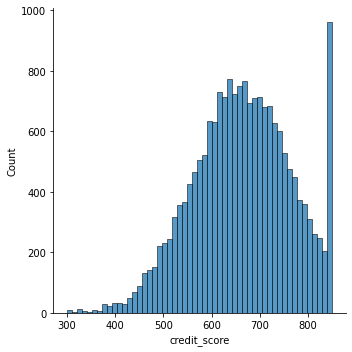

In [17]:
sns.displot(predictors, x='credit_score')

In [18]:
predictors.corr()['credit_score']
print(np.mean(predictors.credit_score), np.nanmedian(predictors.credit_score))
# impute credict_score with mean
predictors.credit_score = predictors.credit_score.fillna(np.mean(predictors.credit_score))

663.6459067178287 664.601282184358


In [19]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hhld_id          20000 non-null  int64  
 1   drvr_cnt         20000 non-null  int64  
 2   veh_cnt          20000 non-null  int64  
 3   min_age          20000 non-null  float64
 4   hoh_age          20000 non-null  float64
 5   max_age          20000 non-null  float64
 6   avg_age          20000 non-null  float64
 7   min_mon_lic      20000 non-null  float64
 8   hoh_mon_lic      20000 non-null  float64
 9   max_mon_lic      20000 non-null  float64
 10  avg_mon_lic      20000 non-null  float64
 11  cnt_yth          20000 non-null  int64  
 12  cnt_female       20000 non-null  int64  
 13  cnt_male         20000 non-null  int64  
 14  cnt_married      20000 non-null  int64  
 15  cnt_single       20000 non-null  int64  
 16  hoh_married      20000 non-null  int64  
 17  cnt_auto    

### Subsequence Loss Experience

In [20]:
# check that all hhld_id are unique
len(np.unique(loss.hhld_id)) == len(loss.hhld_id)

True

In [ ]:
# make sure that claim indicator is correctly labeled
all(loss.hhld_id[loss.pd_amt > 0] == loss.hhld_id[loss.future_clm_ind == 1])

True

In [ ]:
# validate that the loss ratio is correct
all((loss.loss_ratio <= loss.pd_amt / loss.premium + 0.00001) 
    & (loss.loss_ratio >= loss.pd_amt / loss.premium - 0.00001))

True

## Step 1.1 Aggregat Claim Data and Create Count Variables

In [21]:
# extract year from claim dates
claims['Claim_Year'] = claims.clm_dates.dt.year

In [22]:
claims.head()

,hhld_id,clm_dates,aft_ind,pd_amt,Claim_Year
3,10347,2014-02-09,0,428.48,2014
6,2388,2016-08-01,1,2092.55,2016
8,8845,2015-08-10,1,6133.88,2015
11,14318,2015-11-26,0,157.36,2015
12,13283,2012-04-28,0,164.90,2012


In [23]:
# sanity check
np.unique(claims.clm_dates.dt.year, return_counts = True)

(array([2012, 2013, 2014, 2015, 2016]), array([720, 675, 704, 712, 718]))

In [24]:
# check unique type of indicator if claims is at fault, make sure there is no NA's
np.unique(claims.aft_ind, return_counts = True)

(array([0, 1]), array([2459, 1070]))

In [25]:
claims_agg = claims.groupby(['hhld_id', 'Claim_Year'])['aft_ind'].agg(at_fault_cnt = lambda x:sum(x == 1), 
                                                                      not_at_fault_cnt = lambda x:sum(x == 0)).reset_index()

In [26]:
claims_agg.columns

Index(['hhld_id', 'Claim_Year', 'at_fault_cnt', 'not_at_fault_cnt'], dtype='object')

In [27]:
claims_agg.head()

,hhld_id,Claim_Year,at_fault_cnt,not_at_fault_cnt
0,2,2015,0,1
1,13,2016,1,0
2,27,2013,0,1
3,36,2013,0,1
4,49,2014,0,1


In [28]:
# sanity check
claims_agg[claims_agg.hhld_id == 8845]

,hhld_id,Claim_Year,at_fault_cnt,not_at_fault_cnt
1536,8845,2015,1,0


## Step 1.2 Merge Predictor Data, Subsequent Loss Data, and Aggregated Claim Data

In [29]:
all(np.unique(predictors.hhld_id) == np.unique(loss.hhld_id))

True

In [30]:
data = pd.merge(predictors, loss, on = 'hhld_id')

In [31]:
new_data = data.merge(claims_agg, on = 'hhld_id', how = 'left')
new_data

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,premium,pd_amt,loss_ratio,future_clm_ind,Claim_Year,at_fault_cnt,not_at_fault_cnt
0,15937,2,1,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0,2,0,1,1,1,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.000000,25000.0,0,0,0.0,0,0,0,1,1,1,100,100,825.949106,35741,133.6,0.0,0.0,0,2012.0,1.0,1.0
1,13778,1,1,35.644631,35.644631,35.644631,35.644631,235.735566,235.735566,235.735566,235.735566,0,0,1,0,1,0,1,0,0.0,0,0,0.0,0,OTHER,1.500000,25000.0,1,1,1.0,0,0,0,1,1,0,25,25,684.650216,87884,145.8,0.0,0.0,0,NaN,NaN,NaN
2,16063,1,1,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,1,0,1,0,0.0,0,2,2.0,0,FARMERS,5.000000,50000.0,0,1,1.0,0,0,0,1,1,1,100,100,596.318289,81525,167.0,0.0,0.0,0,NaN,NaN,NaN
3,12789,1,1,17.882127,17.882127,17.882127,17.882127,22.585530,22.585530,22.585530,22.585530,1,1,0,0,1,0,1,0,0.0,0,0,0.0,0,OTHER,0.000000,100000.0,1,0,1.0,0,0,1,1,1,1,100,100,636.757859,35741,150.3,0.0,0.0,0,NaN,NaN,NaN
4,5122,1,1,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1,0,1,0,1,0,1,0,0.0,0,0,0.0,0,OTHER,2.500000,25000.0,0,0,1.0,0,0,0,0,1,1,50,50,669.569992,59792,117.0,0.0,0.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20243,7971,1,1,22.317612,22.317612,22.317612,22.317612,75.811340,75.811340,75.811340,75.811340,0,0,1,0,1,0,1,0,0.0,0,0,0.0,0,MISSING,3.169438,50000.0,0,1,1.0,0,0,0,0,0,0,25,25,730.524944,52758,80.0,0.0,0.0,0,NaN,NaN,NaN
20244,5143,2,1,22.480599,50.319074,50.319074,36.399836,77.767185,411.828883,411.828883,244.798034,0,1,1,1,1,1,1,0,0.0,0,0,0.0,0,ALLSTATE,3.500000,100000.0,0,1,1.0,0,0,0,0,0,0,50,50,733.680364,92002,80.0,0.0,0.0,0,NaN,NaN,NaN
20245,2554,2,2,42.579635,47.374177,47.374177,44.976906,318.955620,376.490121,376.490121,347.722870,0,0,2,2,0,1,2,0,0.0,0,1,0.5,0,PROGRESSIVE,5.000000,50000.0,1,1,2.0,0,0,0,1,1,1,25,25,689.594122,77155,222.3,0.0,0.0,0,2015.0,0.0,1.0
20246,6,1,1,46.832826,46.832826,46.832826,46.832826,369.993911,369.993911,369.993911,369.993911,0,1,0,0,1,0,1,0,0.0,0,0,0.0,0,MISSING,3.169438,50000.0,1,1,0.0,0,1,0,1,1,1,25,25,682.152566,87035,150.3,0.0,0.0,0,NaN,NaN,NaN


In [ ]:
np.unique(new_data.hhld_id)[np.unique(new_data.hhld_id, return_counts = True)[1] != 1]

array([   70,   430,   533,   537,   603,   673,   678,   790,   793,
         807,   818,   953,  1018,  1066,  1085,  1283,  1299,  1416,
        1417,  1621,  1658,  1797,  2132,  2325,  2332,  2358,  2558,
        2645,  2811,  2887,  2916,  3044,  3089,  3184,  3311,  3332,
        3419,  3473,  3576,  3753,  3774,  3903,  3956,  4030,  4099,
        4218,  4327,  4385,  4391,  4433,  4510,  4784,  4855,  4966,
        5165,  5194,  5276,  5282,  5332,  5462,  5547,  5669,  5774,
        5855,  5879,  6077,  6108,  6314,  6343,  6364,  6374,  6450,
        6518,  6693,  6703,  6769,  6860,  7175,  7182,  7267,  7275,
        7378,  7462,  7554,  7575,  7689,  7797,  7910,  7954,  8172,
        8189,  8193,  8225,  8311,  8368,  8405,  8413,  8592,  8656,
        8709,  8729,  8779,  8823,  8843,  8880,  9301,  9359,  9453,
        9467,  9519,  9793, 10034, 10328, 10499, 10561, 10569, 10570,
       10631, 10691, 10719, 10731, 10984, 11066, 11125, 11145, 11440,
       11585, 11590,

In [32]:
# sanity check
new_data[new_data.hhld_id == 19906]

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,premium,pd_amt,loss_ratio,future_clm_ind,Claim_Year,at_fault_cnt,not_at_fault_cnt
13591,19906,3,4,27.140642,36.409659,70.415101,44.655134,133.687699,244.915909,652.981218,343.861609,0,0,3,3,0,1,4,0,0.0,0,0,0.0,0,OTHER,3.0,250000.0,0,0,2.0,0,2,0,1,1,1,50,50,850.0,87989,325.6,0.0,0.0,0,2012.0,0.0,1.0
13592,19906,3,4,27.140642,36.409659,70.415101,44.655134,133.687699,244.915909,652.981218,343.861609,0,0,3,3,0,1,4,0,0.0,0,0,0.0,0,OTHER,3.0,250000.0,0,0,2.0,0,2,0,1,1,1,50,50,850.0,87989,325.6,0.0,0.0,0,2016.0,0.0,1.0


In [33]:
# loss_ratio is calucated by dividing pd_amt with premium, so we can drop one of them (i.e. pd_amt) to reduce multi-collinearity
new_data = new_data.drop(columns = ['pd_amt'])

In [34]:
new_data.shape

(20248, 46)

### missing value imputation
* Claim_Year, at_fault_cnt, not_at_fault_cnt would be NA if the associated household id doesn't appear in the Claim Data. We can assume that if a household doesn't appear in the Claim Data means it didn't file a claim in the past 5 years. As a result, its at_fault_cnt and not_at_fault_cnt would be 0 and we would impute the NA's with 0

* To handle the excessive amount of NA's in Claim_Year, we can assume that a household is equally likely to file claims at each of the last 5 years, so the claim year is not as important and we can drop the Claim_Year column.

In [35]:
new_data.loc[new_data.at_fault_cnt.isnull(), ['at_fault_cnt', 'not_at_fault_cnt']] = 0

In [36]:
new_data = new_data.drop(columns = 'Claim_Year')

In [37]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20248 entries, 0 to 20247
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hhld_id           20248 non-null  int64  
 1   drvr_cnt          20248 non-null  int64  
 2   veh_cnt           20248 non-null  int64  
 3   min_age           20248 non-null  float64
 4   hoh_age           20248 non-null  float64
 5   max_age           20248 non-null  float64
 6   avg_age           20248 non-null  float64
 7   min_mon_lic       20248 non-null  float64
 8   hoh_mon_lic       20248 non-null  float64
 9   max_mon_lic       20248 non-null  float64
 10  avg_mon_lic       20248 non-null  float64
 11  cnt_yth           20248 non-null  int64  
 12  cnt_female        20248 non-null  int64  
 13  cnt_male          20248 non-null  int64  
 14  cnt_married       20248 non-null  int64  
 15  cnt_single        20248 non-null  int64  
 16  hoh_married       20248 non-null  int64 

## Step 1.3 Build Model

### Data Preparation

In [38]:
# drop the household id as it has no real meaning
X = new_data.drop(columns = ['future_clm_ind', 'hhld_id'])
y = new_data.future_clm_ind.values

In [39]:
print(X.shape, y.shape)

(20248, 43) (20248,)


In [40]:
# imbalance dataset, perform upsampling later
y = new_data.future_clm_ind.values
Counter(y)

Counter({0: 19368, 1: 880})

### Convert categorical to numeric

In [41]:
cat_cols = list(X.select_dtypes('object').columns)
num_cols = list(X.columns[~X.columns.isin(cat_cols)])

In [42]:
encoder = OneHotEncoder()
X_encoded = pd.DataFrame(encoder.fit_transform(X[cat_cols]).toarray(), index = X.index)
X_encoded.columns = encoder.get_feature_names(cat_cols)
X_encoded

,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_MISSING,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
20243,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20246,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [43]:
X = X.drop(columns = cat_cols)

In [44]:
X = pd.concat([X, X_encoded], axis=1)

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20248 entries, 0 to 20247
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drvr_cnt                       20248 non-null  int64  
 1   veh_cnt                        20248 non-null  int64  
 2   min_age                        20248 non-null  float64
 3   hoh_age                        20248 non-null  float64
 4   max_age                        20248 non-null  float64
 5   avg_age                        20248 non-null  float64
 6   min_mon_lic                    20248 non-null  float64
 7   hoh_mon_lic                    20248 non-null  float64
 8   max_mon_lic                    20248 non-null  float64
 9   avg_mon_lic                    20248 non-null  float64
 10  cnt_yth                        20248 non-null  int64  
 11  cnt_female                     20248 non-null  int64  
 12  cnt_male                       20248 non-null 

### train test split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24, stratify = y)

In [47]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16198, 51) (4050, 51) (16198,) (4050,)


In [48]:
print(f'class 1: {sum(y_train == 1)}, class 0: {sum(y_train == 0)}')

class 1: 704, class 0: 15494


In [49]:
print(f'class 1: {sum(y_test == 1)}, class 0: {sum(y_test == 0)}')

class 1: 176, class 0: 3874


### Normalize data

In [50]:
Scaler = MinMaxScaler()
X_train[num_cols] = Scaler.fit_transform(X_train[num_cols])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [51]:
X_train.head()

,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,time_w_carr,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,premium,loss_ratio,at_fault_cnt,not_at_fault_cnt,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_MISSING,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE
18690,0.333333,0.000000,0.182099,0.399746,0.399746,0.294710,0.182099,0.399746,0.399746,0.294710,0.000000,0.25,0.25,0.5,0.00,1.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.0,0.0,0.25,0.0,0.00,0.0,0.00,0.00,0.25,0.000000,0.000000,0.765627,0.658538,0.006716,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15091,0.333333,0.333333,0.361718,0.414199,0.414199,0.391884,0.361718,0.414199,0.414199,0.391884,0.000000,0.00,0.50,0.0,0.50,0.0,0.50,0.0,0.0,0.0,0.2,0.1,0.0,0.400000,0.333333,1.0,0.0,0.00,0.0,0.50,1.0,0.50,0.50,0.25,0.000000,0.000000,0.378704,0.846418,0.384515,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11517,0.333333,0.333333,0.412327,0.554593,0.554593,0.488716,0.412327,0.554593,0.554593,0.488716,0.000000,0.50,0.00,0.0,0.50,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.633888,0.111111,0.0,0.0,0.25,0.0,0.25,0.0,0.25,0.25,0.25,1.000000,1.000000,0.807932,0.173195,0.234328,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14797,0.000000,0.000000,0.318817,0.312887,0.312887,0.318817,0.318817,0.312887,0.312887,0.318817,0.000000,0.00,0.25,0.0,0.25,0.0,0.25,0.0,0.0,0.0,0.2,0.2,0.0,0.633888,0.111111,1.0,1.0,0.25,0.0,0.00,0.0,0.25,0.25,0.25,0.000000,0.000000,0.661174,0.972504,0.146082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2587,0.666667,0.333333,0.000000,0.220310,0.314494,0.181647,0.000000,0.220310,0.314494,0.181647,0.333333,0.25,0.50,0.5,0.25,1.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,1.000000,0.0,1.0,0.50,0.0,0.00,0.0,0.50,0.50,0.25,0.111111,0.111111,0.557851,0.963138,0.442164,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Upsampling using Smote

In [52]:
smt = SMOTETomek(random_state = 24)
X_res, y_res = smt.fit_resample(X_train.to_numpy(),y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [53]:
print(X_res.shape, y_res.shape)

(30988, 51) (30988,)


In [54]:
# Validate that we have a balance dataset 
Counter(y_res)

Counter({0: 15494, 1: 15494})

In [55]:
X_res_df = pd.DataFrame(X_res, columns = X_train.columns)

In [56]:
X_res_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30988 entries, 0 to 30987
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drvr_cnt                       30988 non-null  float64
 1   veh_cnt                        30988 non-null  float64
 2   min_age                        30988 non-null  float64
 3   hoh_age                        30988 non-null  float64
 4   max_age                        30988 non-null  float64
 5   avg_age                        30988 non-null  float64
 6   min_mon_lic                    30988 non-null  float64
 7   hoh_mon_lic                    30988 non-null  float64
 8   max_mon_lic                    30988 non-null  float64
 9   avg_mon_lic                    30988 non-null  float64
 10  cnt_yth                        30988 non-null  float64
 11  cnt_female                     30988 non-null  float64
 12  cnt_male                       30988 non-null 

### Model Building

In [57]:
# normalize X_test using the scale for X_train
X_test[num_cols] = Scaler.transform(X_test[num_cols])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [58]:
X_test.head()

,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,time_w_carr,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,premium,loss_ratio,at_fault_cnt,not_at_fault_cnt,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_MISSING,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE
13023,0.333333,0.000000,0.135846,0.538044,0.538044,0.342044,0.135846,0.538044,0.538044,0.342044,0.0,0.25,0.25,0.50,0.00,1.0,0.00,0.333333,0.0,0.0,0.2,0.1,0.0,1.000000,0.000000,0.0,1.0,0.25,0.0,0.00,0.0,0.25,0.25,0.25,0.333333,0.333333,0.610189,0.829559,0.177239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16667,0.333333,0.333333,0.079396,0.452531,0.452531,0.270252,0.079396,0.452531,0.452531,0.270252,0.0,0.25,0.25,0.25,0.25,1.0,0.50,0.000000,0.0,0.0,0.0,0.0,0.0,0.200000,0.333333,0.0,0.0,0.25,0.0,0.25,0.0,0.00,0.25,0.25,0.333333,0.333333,0.850409,0.000000,0.159701,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8701,0.333333,0.000000,0.281676,0.419283,0.419283,0.354453,0.281676,0.419283,0.419283,0.354453,0.0,0.50,0.00,0.25,0.25,1.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,1.0,1.0,0.00,0.0,0.25,1.0,0.25,0.25,0.25,0.333333,0.333333,0.629107,0.475598,0.146082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1681,0.000000,0.000000,0.239555,0.235099,0.235099,0.239555,0.239555,0.235099,0.235099,0.239555,0.0,0.25,0.00,0.00,0.25,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.0,0.633888,0.111111,1.0,1.0,0.00,0.0,0.25,1.0,0.00,0.00,0.25,0.333333,0.333333,0.714653,0.797380,0.041978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7566,0.333333,0.666667,0.067549,0.223588,0.223588,0.147688,0.067549,0.223588,0.223588,0.147688,0.0,0.00,0.50,0.50,0.00,1.0,0.75,0.000000,0.0,0.0,0.6,0.3,0.0,0.200000,0.333333,0.0,1.0,0.25,0.0,0.50,0.0,0.50,0.50,0.00,0.000000,0.000000,0.847814,0.448882,0.438806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Model 1: Logistic Regression with Feature Reduction

In [ ]:
# recursive feature reduction
lr = LogisticRegression()
rfecv = RFECV(estimator = lr, cv = 10, scoring = 'accuracy', step = 1 )
rfecv.fit(X_res_df, y_res)

RFECV(cv=10,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

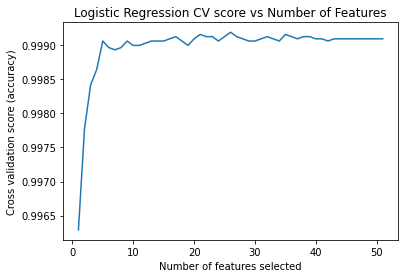

In [ ]:
plt.figure()
plt.title('Logistic Regression CV score vs Number of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
# import features selected by rfecv
X_res_df.columns[rfecv.support_]

Index(['drvr_cnt', 'veh_cnt', 'min_age', 'avg_age', 'min_mon_lic',
       'max_mon_lic', 'avg_mon_lic', 'cnt_yth', 'cnt_male', 'hoh_married',
       'cnt_auto', 'cnt_minr_viol', 'cnt_lic_susp', 'prior_bi', 'veh_lien_cnt',
       'veh_lease_cnt', 'veh_w_coll_cnt', 'veh_w_ers_cnt', 'credit_score',
       'premium', 'loss_ratio', 'at_fault_cnt', 'not_at_fault_cnt',
       'curnt_insurer_FARMERS', 'curnt_insurer_LIBERTY MUTUAL',
       'curnt_insurer_MISSING'],
      dtype='object')

In [ ]:
rfecv_probs = rfecv.predict_proba(X_test)
y_pred = rfecv.predict(X_test)
print('Recall: ', recall_score(y_test, y_pred))
print('AUC: ', roc_auc_score(y_test, rfecv_probs[:,1]))
print('Accuracy: ', rfecv.score(X_test, y_test))

Recall:  0.9943181818181818
AUC:  0.9955223048763318
Accuracy:  0.9992592592592593


In [ ]:
np.unique(y_pred, return_counts = True)

(array([0, 1]), array([3873,  177]))

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3874
           1       0.99      0.99      0.99       176

    accuracy                           1.00      4050
   macro avg       0.99      1.00      1.00      4050
weighted avg       1.00      1.00      1.00      4050



#### Model 2: Logistic Regression with Regularization

In [ ]:
# decide on regularization
lr_C = [0.001, 0.01, 0.1, 1, 10, 100]
lr_scores = []
for C in lr_C:
    lr_v = LogisticRegression(C=C)
    lr_v.fit(X_res_df, y_res)
    lr_scores.append(lr_v.score(X_test, y_test))
C_bst = lr_C[np.argmax(lr_scores)]
print(C_bst)

In [ ]:
lr = LogisticRegression(C = C_bst)
lr.fit(X_res_df, y_res)
lr_probs = lr.predict_proba(X_test)
y_pred = lr.predict(X_test)
print('Recall: ', recall_score(y_test, y_pred))
print('AUC: ', roc_auc_score(y_test, lr_probs[:,1]))
print('Accuracy: ', lr.score(X_test, y_test))
print('F1 Score: ', f1_score(y_test, y_pred))

Recall:  0.9943181818181818
AUC:  0.9928632609001736
Accuracy:  0.9108641975308642
F1 Score:  0.4922644163150492


#### Model 3: RandomForest

In [61]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

In [64]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 3, verbose=2, random_state=42, 
                               n_jobs = -1)

rf_random.fit(X_res_df, y_res)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [65]:
rf_random.best_params_

{'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 233}

In [67]:
clf = RandomForestClassifier(n_estimators=233, max_depth=100, min_samples_leaf=2,
                             min_samples_split=2, max_features='auto')
clf.fit(X_res_df, y_res)
clf.score(X_test, y_test)

1.0

In [68]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_res_df.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:20]                                   

,importance
loss_ratio,0.412993
prior_bi,0.235658
credit_score,0.167369
curnt_insurer_MISSING,0.057692
avg_mon_lic,0.008561
veh_w_ers_cnt,0.008313
veh_w_comp_cnt,0.008256
max_age,0.008111
veh_w_coll_cnt,0.008053
veh_lien_cnt,0.007934


In [69]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3874
           1       1.00      1.00      1.00       176

    accuracy                           1.00      4050
   macro avg       1.00      1.00      1.00      4050
weighted avg       1.00      1.00      1.00      4050



In [70]:
np.unique(y_pred, return_counts = True)

(array([0, 1]), array([3874,  176]))

In [71]:
print('F1 Score: ', f1_score(y_test, y_pred))

F1 Score:  1.0


#### Model 4: Neural Network

In [ ]:
tf_seed = 24
tf.keras.backend.clear_session()
tf.random.set_seed(tf_seed)

inputs = keras.Input(shape=(X_res_df.shape[1],))
x = keras.layers.Dense(32, activation='relu')(inputs)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 51)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1664      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,697
Trainable params: 1,697
Non-trainable params: 0
_________________________________________________________________


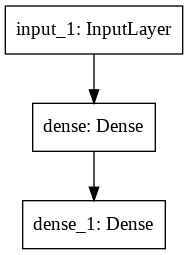

In [ ]:
keras.utils.plot_model(model)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,
                                              restore_best_weights=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_res_df, y_res, 
          validation_split = 0.2,
          batch_size=32, epochs=20, verbose=1, callbacks=[early_stop])

Epoch 1/20
775/775 [==============================] - 3s 3ms/step - loss: 0.4099 - accuracy: 0.8132 - val_loss: 0.0939 - val_accuracy: 0.9971
Epoch 2/20
775/775 [==============================] - 2s 3ms/step - loss: 0.0466 - accuracy: 0.9968 - val_loss: 0.0276 - val_accuracy: 0.9984
Epoch 3/20
775/775 [==============================] - 2s 3ms/step - loss: 0.0188 - accuracy: 0.9983 - val_loss: 0.0116 - val_accuracy: 0.9990
Epoch 4/20
775/775 [==============================] - 2s 3ms/step - loss: 0.0103 - accuracy: 0.9991 - val_loss: 0.0092 - val_accuracy: 0.9990
Epoch 5/20
775/775 [==============================] - 2s 3ms/step - loss: 0.0059 - accuracy: 0.9997 - val_loss: 0.0084 - val_accuracy: 0.9987
Epoch 6/20
775/775 [==============================] - 2s 3ms/step - loss: 0.0047 - accuracy: 0.9997 - val_loss: 0.0070 - val_accuracy: 0.9989
Epoch 7/20
775/775 [==============================] - 2s 3ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.0032 - val_accuracy: 0.9992
Epoch 

In [ ]:
model.evaluate(X_test, y_test, return_dict = True)

127/127 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.9998


{'accuracy': 0.9997530579566956, 'loss': 0.006988853216171265}

In [ ]:
def func_conv(x):
  if x >= 0.5:
    return 1
  else:
    return 0

y_pred = model.predict(X_test).reshape(1,-1)
y_pred = np.apply_along_axis(func_conv, 0, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3874
           1       1.00      0.99      1.00       176

    accuracy                           1.00      4050
   macro avg       1.00      1.00      1.00      4050
weighted avg       1.00      1.00      1.00      4050



In [ ]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([3875,  175]))